### 實作可解釋模型LRP，以ExplainableAI.jl 和 Flux.jl 為例分析圖片Heatmap
##### 作者: Eason Chu
*made for 國立政治大學 National ChengChi University 1111701893001_人工智慧應用專題_個人報告四* 

###### 備註：由於此次開發環境為Julia，請使用Julia 1.7.2+並依序安裝相關模組


#### 首先我們利用Pkg下載會使用到的相關模組

In [1]:
#import Pkg; Pkg.add("Flux")
using Flux   

In [2]:
#Pkg.add("ExplainableAI")
using ExplainableAI

In [3]:
#Pkg.add("ImageMagick");Pkg.add("HTTP");Pkg.add("FileIO")
using HTTP, FileIO, ImageMagick 

In [4]:
#Pkg.add("ImageShow")
using ImageShow 

In [5]:
#Pkg.add("Metalhead")
using Metalhead                         

#### 我們利用VGG建立深度學習模型

In [6]:
model = VGG().layers
model = strip_softmax(flatten_chain(model))

Chain(
  Conv((3, 3), 3 => 64, relu, pad=1),   # 1_792 parameters
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 256 => 512, relu, pad=1),  # 1_180_160 parameters
  Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
  Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
  Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
  Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
  MaxPool((2, 2)),
  MLUtils.flatten,
  Dense(25088 => 4096, relu),           # 102_764_544 par

#### 然後，下載圖片

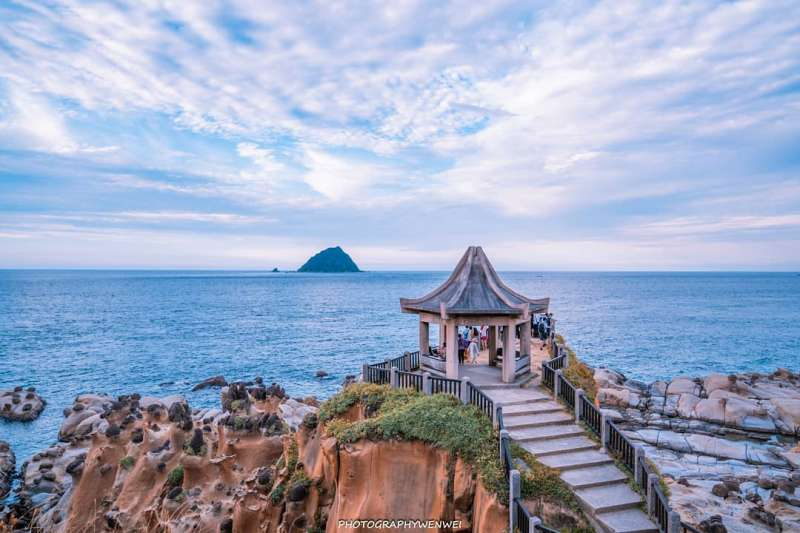

In [7]:
# 載入圖片
url = HTTP.URI("https://image.cache.storm.mg/styles/smg-800x533-fp/s3/media/image/2020/11/07/20201107-092915_U13380_M651499_4ac4.jpg?itok=6KFZde7p")
img = load(url)
input = preprocess_imagenet(img)
input = reshape(input, 224, 224, 3, :)  # 轉成WHCN格式

224×224×3×1 Array{Float32, 4}:
[:, :, 1, 1] =
 1.44404   1.44404   1.28992  1.22142  …   0.0740646  -0.559551   -0.919171
 1.42692   1.39267   1.3413   1.28992     -0.371179   -0.422553   -0.645175
 1.42692   1.39267   1.39267  1.39267     -0.30268     0.0740646  -0.30268
 1.54679   1.42692   1.42692  1.47829      0.330936    0.0740646  -0.199932
 1.70092   1.49542   1.44404  1.47829      0.827554    0.536433    0.348061
 1.73517   1.59817   1.52967  1.51254  …   0.793304    0.913177    0.536433
 1.80366   1.75229   1.63242  1.49542     -0.285555   -0.251306   -0.251306
 1.80366   1.80366   1.68379  1.52967     -0.713674   -0.542427   -0.0629335
 1.78654   1.78654   1.68379  1.49542     -0.508177   -0.0458088  -0.0629335
 1.75229   1.73517   1.61529  1.4098       0.622057   -0.0115593  -0.234181
 1.61529   1.59817   1.47829  1.30705  …  -0.576676   -0.508177   -0.713674
 1.49542   1.42692   1.35842  1.23855     -0.33693    -0.593801   -0.799298
 1.47829   1.46117   1.4098   1.25567    

#### 我們先利用基礎LRP來檢視Heatmap

In [8]:
analyzer = LRP(model)
expl = analyze(input, analyzer)    

Explanation{Array{Float32, 4}, Matrix{Float32}, Vector{CartesianIndex{2}}, DataType}([9.4925815f-7 2.3547975f-7 … 2.3662065f-7 3.8922474f-7; -4.0522264f-7 2.083447f-6 … -1.2712118f-7 -4.496768f-8; … ; -4.4501246f-7 8.6302623f-7 … -1.6356962f-8 2.900294f-7; -1.1800264f-8 -8.8995756f-7 … -1.5740274f-6 1.4835344f-7;;; 2.4569968f-7 -1.6809635f-6 … -1.541519f-7 -1.7532898f-7; -6.792072f-7 2.8018083f-6 … 1.3299655f-6 1.3542242f-6; … ; 2.534629f-7 4.5909863f-7 … 5.7486784f-7 -9.4572655f-8; -3.3605878f-7 -2.0308701f-7 … 1.2450482f-8 -2.3272412f-8;;; -9.8581054f-8 3.5954345f-6 … -3.8093035f-7 3.9292263f-9; -2.5850784f-7 -3.1537454f-6 … 1.5388787f-6 7.3036415f-7; … ; 1.0574693f-6 4.8563584f-6 … 2.8942395f-7 -5.1715837f-10; 8.5697746f-7 -4.0557214f-7 … -1.822424f-7 -5.4337965f-9;;;;], Float32[-0.0010233287; 0.0016238008; … ; 0.00030402956; 0.0054764617;;], CartesianIndex{2}[CartesianIndex(890, 1)], :LRP, Nothing)

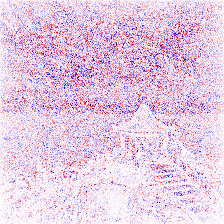

In [9]:
heatmap(expl)

In [11]:
analyze(input, analyzer) 

Explanation{Array{Float32, 4}, Matrix{Float32}, Vector{CartesianIndex{2}}, DataType}([9.4925815f-7 2.3547975f-7 … 2.3662065f-7 3.8922474f-7; -4.0522264f-7 2.083447f-6 … -1.2712118f-7 -4.496768f-8; … ; -4.4501246f-7 8.6302623f-7 … -1.6356962f-8 2.900294f-7; -1.1800264f-8 -8.8995756f-7 … -1.5740274f-6 1.4835344f-7;;; 2.4569968f-7 -1.6809635f-6 … -1.541519f-7 -1.7532898f-7; -6.792072f-7 2.8018083f-6 … 1.3299655f-6 1.3542242f-6; … ; 2.534629f-7 4.5909863f-7 … 5.7486784f-7 -9.4572655f-8; -3.3605878f-7 -2.0308701f-7 … 1.2450482f-8 -2.3272412f-8;;; -9.8581054f-8 3.5954345f-6 … -3.8093035f-7 3.9292263f-9; -2.5850784f-7 -3.1537454f-6 … 1.5388787f-6 7.3036415f-7; … ; 1.0574693f-6 4.8563584f-6 … 2.8942395f-7 -5.1715837f-10; 8.5697746f-7 -4.0557214f-7 … -1.822424f-7 -5.4337965f-9;;;;], Float32[-0.0010233287; 0.0016238008; … ; 0.00030402956; 0.0054764617;;], CartesianIndex{2}[CartesianIndex(890, 1)], :LRP, Nothing)

#### 接著，我們嘗試組合不同算法分別檢視其成果

In [12]:
#LRP+EpsilonAlpha2Beta1
composite = EpsilonAlpha2Beta1()
analyzer_2 = LRP(model,composite)
expl = analyze(input, analyzer_2)   

Explanation{Array{Float32, 4}, Matrix{Float32}, Vector{CartesianIndex{2}}, DataType}([1.5953053f-10 3.6714584f-10 … 1.3993864f-9 6.4092203f-9; 3.433779f-10 4.4345155f-10 … 1.0810215f-9 3.627017f-9; … ; 1.26690685f-8 2.379603f-8 … 2.7797293f-9 1.15685f-9; 1.19764625f-8 1.30026905f-8 … 9.937198f-9 1.2160172f-9;;; 2.0663704f-10 3.699589f-10 … 1.3735672f-8 1.4894444f-8; 3.949435f-10 6.8861084f-10 … 1.1172592f-8 1.714768f-8; … ; 1.1256045f-8 3.705456f-8 … -7.352754f-10 -1.2687844f-9; 1.1514121f-8 2.533657f-8 … 7.1418245f-9 -6.1037864f-10;;; 3.3822048f-10 7.7796314f-10 … 9.776303f-9 9.882754f-9; 4.8490606f-10 1.0076576f-9 … 1.5525218f-8 1.5228272f-8; … ; 2.8875306f-8 7.685705f-8 … -3.2295122f-10 8.86427f-12; 2.8545287f-8 4.2072386f-8 … 5.578371f-9 -2.9610793f-11;;;;], Float32[-0.0010233287; 0.0016238008; … ; 0.00030402956; 0.0054764617;;], CartesianIndex{2}[CartesianIndex(890, 1)], :LRP, Nothing)

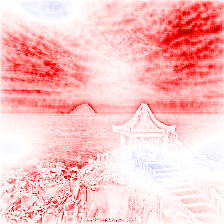

In [13]:
heatmap(expl)

In [16]:
#LRP+EpsilonPlusFlat
composite = EpsilonPlusFlat()
analyzer_2 = LRP(model,composite)
expl = analyze(input, analyzer_2)   

Explanation{Array{Float32, 4}, Matrix{Float32}, Vector{CartesianIndex{2}}, DataType}([1.9466115f-10 3.9454257f-10 … 8.187459f-9 5.091778f-9; 3.2369368f-10 6.4172073f-10 … 1.2312253f-8 7.738261f-9; … ; 2.0082886f-8 4.2707835f-8 … 4.379768f-9 2.5473368f-9; 1.2392809f-8 2.6548392f-8 … 2.8675786f-9 1.5853331f-9;;; 1.9466115f-10 3.9454257f-10 … 8.187459f-9 5.091778f-9; 3.2369368f-10 6.4172073f-10 … 1.2312253f-8 7.738261f-9; … ; 2.0082886f-8 4.2707835f-8 … 4.379768f-9 2.5473368f-9; 1.2392809f-8 2.6548392f-8 … 2.8675786f-9 1.5853331f-9;;; 1.9466115f-10 3.9454257f-10 … 8.187459f-9 5.091778f-9; 3.2369368f-10 6.4172073f-10 … 1.2312253f-8 7.738261f-9; … ; 2.0082886f-8 4.2707835f-8 … 4.379768f-9 2.5473368f-9; 1.2392809f-8 2.6548392f-8 … 2.8675786f-9 1.5853331f-9;;;;], Float32[-0.0010233287; 0.0016238008; … ; 0.00030402956; 0.0054764617;;], CartesianIndex{2}[CartesianIndex(890, 1)], :LRP, Nothing)

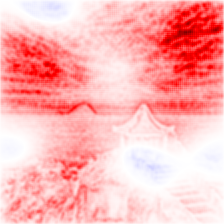

In [17]:
heatmap(expl)

綜合以上三種算法，所呈現的Heatmap都有所差異，但組合LRP與Epsilon可使Heatmap對於圖片特徵顯示較為明顯。

#### References:
ExplainableAI.jl: https://docs.juliahub.com/ExplainableAI/F3ilo/0.5.6/

Flux.jl: https://fluxml.ai/Flux.jl/stable/